In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import itertools
import copy
import os
import sys

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from math import sqrt

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path) 
from train_utils import *

cuda:0


In [ ]:
experiment_name = "AirlinePassengers"

# Model

In [2]:
class Square(torch.nn.Module):
    def __init__(self):
        super().__init__()
 
    def forward(self, t):
        return torch.pow(t, 2)

class Cube(torch.nn.Module):
    def __init__(self):
        super().__init__()
 
    def forward(self, t):
        return torch.pow(t, 3)
    
class Printer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, t):
        # print(t)
        print(t.shape)
        return t


class PINPOINT_Small(nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, output_horizon):
        super(PINPOINT_Small, self).__init__()

        n_kernels_1 = 32
        kernel_size_1 = 3
        out_conv_1 = n_kernels_1 * (input_size - kernel_size_1 + 1)

        self.main = nn.Sequential(           
            nn.Conv1d(in_channels=1, out_channels=n_kernels_1, kernel_size=kernel_size_1),
            Square(),
            nn.Flatten(),      
            
            nn.Linear(out_conv_1, int(out_conv_1/2)), #use without avgpool
            # nn.Linear(int(out_conv_1/2), output_horizon)   
            nn.Linear(int(out_conv_1/2), int(out_conv_1/4)),
            nn.Linear(int(out_conv_1/4), output_horizon)   
        )

    def forward(self, x):
        out = self.main(x)
        return out
    
    def __str__(self):
        return "PINPOINT_Small"

    
class PINPOINT_Medium(nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, output_horizon):
        super(PINPOINT_Medium, self).__init__()
        
        n_kernels_1 = 16
        n_kernels_2 = 32
        kernel_size_1 = 5
        kernel_size_2 = 3
        
        out_conv_1 = input_size - kernel_size_1 + 1
        out_conv_2 = n_kernels_2 * (out_conv_1 - kernel_size_2 + 1)

        self.main = nn.Sequential(           
            nn.Conv1d(in_channels=1, out_channels=n_kernels_1, kernel_size=kernel_size_1),
            Square(),
            nn.Conv1d(in_channels=n_kernels_1, out_channels=n_kernels_2, kernel_size=kernel_size_2),
            Square(),
            nn.Flatten(),      
            
            nn.Linear(out_conv_2, int(out_conv_2/2)), #use without avgpool
            # nn.Linear(int(out_conv_2/4), output_horizon)   
            nn.Linear(int(out_conv_2/2), int(out_conv_2/4)),
            nn.Linear(int(out_conv_2/4), output_horizon)   
        )

    def forward(self, x):
        out = self.main(x)
        return out
    
    def __str__(self):
        return "PINPOINT_Medium"
    
    
class PINPOINT_Big(nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, output_horizon):
        super(PINPOINT_Big, self).__init__()
        
        n_kernels_1 = 8
        n_kernels_2 = 16
        n_kernels_3 = 32
        kernel_size_1 = 7
        kernel_size_2 = 5
        kernel_size_3 = 3
        
        out_conv_1 = input_size - kernel_size_1 + 1
        out_conv_2 = out_conv_1 - kernel_size_2 + 1
        out_conv_3 = n_kernels_3 * (out_conv_2 - kernel_size_3 + 1)

        self.main = nn.Sequential(           
            nn.Conv1d(in_channels=1, out_channels=n_kernels_1, kernel_size=kernel_size_1),
            Square(),
            nn.Conv1d(in_channels=n_kernels_1, out_channels=n_kernels_2, kernel_size=kernel_size_2),
            Square(),
            nn.Conv1d(in_channels=n_kernels_2, out_channels=n_kernels_3, kernel_size=kernel_size_3),
            Square(),
            nn.Flatten(),      
            
            nn.Linear(out_conv_3, int(out_conv_3/2)), #use without avgpool
            nn.Linear(int(out_conv_3/2), int(out_conv_3/4)),
            nn.Linear(int(out_conv_3/4), output_horizon)   
        )

    def forward(self, x):
        out = self.main(x)
        return out
    
    def __str__(self):
        return "PINPOINT_Big"

# Settings

In [12]:
n_experiments = 10
num_epochs = 2000
learning_rate = 0.001

transformation = Identity()

# models = ['PINPOINT_Small', 'PINPOINT_Medium', 'PINPOINT_Big', 'Naive', 'Prophet', 'ARIMA']
models = ['PINPOINT_Small', 'PINPOINT_Medium', 'Naive', 'ARIMA', 'Prophet']
# seq_percentages = [0.05, 0.1, 0.2]  # Obv, needed only for PINPOINT
seq_lengths = [12, 18, 24] #2 * seasonality
forecast_horizons = [1, 3, 6]

In [13]:
names = [f"{m} ({s})" for m in models if m not in ['Naive', 'ARIMA', 'Prophet'] for s in seq_lengths]

In [14]:
names.extend(['Naive', 'ARIMA', 'Prophet'])

In [15]:
names

['PINPOINT_Small (12)',
 'PINPOINT_Small (18)',
 'PINPOINT_Small (24)',
 'PINPOINT_Medium (12)',
 'PINPOINT_Medium (18)',
 'PINPOINT_Medium (24)',
 'Naive',
 'ARIMA',
 'Prophet']

In [16]:
metrics = pd.DataFrame(columns = forecast_horizons, 
                       index = pd.MultiIndex.from_product([names, ['MAE', 'RMSE']], names=["Model", "Metric"]))
                       # index = pd.Index(models, name='Model'))

In [17]:
metrics

1    3    6
Model                Metric               
PINPOINT_Small (12)  MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
PINPOINT_Small (18)  MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
PINPOINT_Small (24)  MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
PINPOINT_Medium (12) MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
PINPOINT_Medium (18) MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
PINPOINT_Medium (24) MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
Naive                MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
ARIMA                MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN
Prophet              MAE     NaN  NaN  NaN
                     RMSE    NaN  NaN  NaN

# Datasets
A recap on the time-series we will use in the followings.

In [18]:
monthly_passengers = pd.read_csv("../data/airline-passengers.csv", parse_dates=['Month'], index_col='Month')
monthly_passengers = monthly_passengers.loc[:, 'Passengers']
monthly_passengers.index.freq = 'MS'
entire_ts = monthly_passengers
train = entire_ts.loc[:pd.Timestamp("1958-01-01")]

validation_length = int(0.05 * len(train))
validation = entire_ts.loc[train.index[-1] + entire_ts.index.freq:train.index[-1] + validation_length * entire_ts.index.freq]
test = entire_ts.loc[validation.index[-1] + entire_ts.index.freq:]

plot_name = "Monthly passengers airline"
yaxis_name = "Passengers"

print(train)
print(validation)
print(test)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1957-09-01    404
1957-10-01    347
1957-11-01    305
1957-12-01    336
1958-01-01    340
Freq: MS, Name: Passengers, Length: 109, dtype: int64
Month
1958-02-01    318
1958-03-01    362
1958-04-01    348
1958-05-01    363
1958-06-01    435
Freq: MS, Name: Passengers, dtype: int64
Month
1958-07-01    491
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, dtype: int64


In [19]:
final_results = {}

In [20]:
for forecast_horizon in forecast_horizons:
    final_results[forecast_horizon] = {}
    
    for model_class in models:
        if model_class == 'ARIMA':
            arima_forecast = np.array([])

            _train = train.copy().append(validation.copy())
            _train = transformation.apply(_train)
            _test = transformation.apply(test.copy())
            
            arima_model = ARIMA_model()
            arima_model.train(_train)
            
            for i in range(0, int(len(_test) / forecast_horizon) + 1):
                arima_forecast = np.append(arima_forecast, arima_model.get_forecast(_train, forecast_horizon))

                for j in range(0, forecast_horizon):
                    if len(_test) != 0:
                        _train[_train.index[-1] + train.index.freq] = _test.iloc[0]
                        _test = _test.iloc[1:]
            
            arima_forecast = transformation.inverse(pd.Series(data=arima_forecast[:len(test)], index=test.index))

            final_results[forecast_horizon][f"forecast_ARIMA"] = arima_forecast
            final_results[forecast_horizon][f"mae_ARIMA"] = mean_absolute_error(test, arima_forecast)
            final_results[forecast_horizon][f"rmse_ARIMA"] = sqrt(mean_squared_error(test, arima_forecast))
            metrics.loc[('ARIMA', 'MAE'), forecast_horizon] = mean_absolute_error(test, arima_forecast)
            metrics.loc[('ARIMA', 'RMSE'), forecast_horizon] = sqrt(mean_squared_error(test, arima_forecast))
        
        elif model_class == 'Prophet':
            prophet_forecast = np.array([])
            
            _train = train.copy().append(validation.copy())
            _train = transformation.apply(_train)
            _test = transformation.apply(test.copy())

            for i in range(0, int(len(_test) / forecast_horizon) + 1):
                prophet_forecast = np.append(prophet_forecast, get_prophet_forecast(_train, forecast_horizon).values)

                for j in range(0, forecast_horizon):
                    if len(_test) != 0:
                        _train[_train.index[-1] + train.index.freq] = _test.iloc[0]
                        _test = _test.iloc[1:]

            prophet_forecast = transformation.inverse(pd.Series(data=prophet_forecast[:len(test)], index=test.index))

            final_results[forecast_horizon][f"forecast_Prophet"] = prophet_forecast
            final_results[forecast_horizon][f"mae_Prophet"] = mean_absolute_error(test, prophet_forecast)
            final_results[forecast_horizon][f"rmse_Prophet"] = sqrt(mean_squared_error(test, prophet_forecast))
            metrics.loc[('Prophet', 'MAE'), forecast_horizon] = mean_absolute_error(test, prophet_forecast)
            metrics.loc[('Prophet', 'RMSE'), forecast_horizon] = sqrt(mean_squared_error(test, prophet_forecast))
        
        elif model_class == 'Naive':
            naive_forecast = np.array([])
            
            _train = train.copy().append(validation.copy())
            _train = transformation.apply(_train)
            _test = transformation.apply(test.copy())
            
            for i in range(0, int(len(_test) / forecast_horizon) + 1):

                for j in range(0, forecast_horizon):
                    naive_forecast = np.append(naive_forecast, _train[-1])

                for j in range(0, forecast_horizon):
                    if len(_test) != 0:
                        _train[_train.index[-1] + train.index.freq] = _test.iloc[0]
                        _test = _test.iloc[1:]

            naive_forecast = transformation.inverse(pd.Series(data=naive_forecast[:len(test)], index=test.index))

            final_results[forecast_horizon][f"forecast_Naive"] = naive_forecast
            final_results[forecast_horizon][f"mae_Naive"] = mean_absolute_error(test, naive_forecast)
            final_results[forecast_horizon][f"rmse_Naive"] = sqrt(mean_squared_error(test, naive_forecast))
            metrics.loc[('Naive', 'MAE'), forecast_horizon] = mean_absolute_error(test, naive_forecast)
            metrics.loc[('Naive', 'RMSE'), forecast_horizon] = sqrt(mean_squared_error(test, naive_forecast))
        
        else:
            matches = { 'PINPOINT_Small': PINPOINT_Small, 
                        'PINPOINT_Medium': PINPOINT_Medium, 
                        'PINPOINT_Big': PINPOINT_Big }
            
            model_name = model_class
            model_class = matches[model_class]
            
            for seq_length in seq_lengths:

                forecast_maes = []
                forecast_rmses = []

                for i in tqdm(range(0, n_experiments)):
                    forecast = np.array([])

                    _train = transformation.apply(train.copy()).values
                    _validation = transformation.apply(validation.copy()).values   
                    _test = transformation.apply(test.copy()).values

                    model = model_class(seq_length, forecast_horizon)
                    model, scaler = train_model(model, _train, _validation, num_epochs, learning_rate, seq_length, forecast_horizon)
                    torch.save(f"models/{experiment_name}_{model_name}.pt")

                    # Compute the forecast on the testing set
                    _train = train.copy().append(validation.copy())
                    _train = transformation.apply(_train)
                    _test = transformation.apply(test.copy())

                    for i in range(0, int(len(_test) / forecast_horizon) + 1):
                        model.eval()

                        inputs = _train.values.reshape(len(_train), 1)

                        inputs_normalized = scaler.transform(inputs)
                        inputs_normalized = torch.FloatTensor(inputs_normalized[-seq_length:]).to(device)

                        predict = model(inputs_normalized.reshape(1, 1, seq_length))
                        predict = scaler.inverse_transform(predict.cpu().detach().numpy())
                        forecast = np.append(forecast, predict)

                        for j in range(0, forecast_horizon):
                            if len(_test) > 0:
                                _train[_train.index[-1] + train.index.freq] = _test.iloc[0]
                                _test = _test.iloc[1:]

                    forecast = transformation.inverse(pd.Series(data=forecast[:len(test)], index=test.index))

                    forecast_maes.append(mean_absolute_error(test, forecast))
                    forecast_rmses.append(sqrt(mean_squared_error(test, forecast)))

                final_results[forecast_horizon][f"forecast_{model}_{seq_length}"] = forecast
                final_results[forecast_horizon][f"mae_{model}_{seq_length}"] = np.mean(forecast_maes)
                final_results[forecast_horizon][f"rmse_{model}_{seq_length}"] = np.mean(forecast_rmses)
                metrics.loc[(f"{model} ({seq_length})", 'MAE'), forecast_horizon] = np.mean(forecast_maes)
                metrics.loc[(f"{model} ({seq_length})", 'RMSE'), forecast_horizon] = np.mean(forecast_rmses)

100%|███████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.54s/it]


Forecast horizon: 1
MAE of model PINPOINT_Small_12: 29.26366424560547
MAE of model PINPOINT_Small_18: 22.5118559773763
MAE of model PINPOINT_Small_24: 53.91708017985026
MAE of model PINPOINT_Medium_12: 63.231921618779495
MAE of model PINPOINT_Medium_18: 71.35836494445802
MAE of model PINPOINT_Medium_24: 67.74263796488444
MAE of model Naive: 45.1
MAE of model ARIMA: 43.54777901240315
MAE of model Prophet: 33.475042164197426
RMSE of model PINPOINT_Small_12: 36.513905309750776
RMSE of model PINPOINT_Small_18: 27.161112050152752
RMSE of model PINPOINT_Small_24: 67.1879716325898
RMSE of model PINPOINT_Medium_12: 86.57113181840256
RMSE of model PINPOINT_Medium_18: 92.52377587132925
RMSE of model PINPOINT_Medium_24: 88.17423130572377
RMSE of model Naive: 52.612102536710445
RMSE of model ARIMA: 51.0123116720123
RMSE of model Prophet: 41.11444624243477
Plot and a comparison...


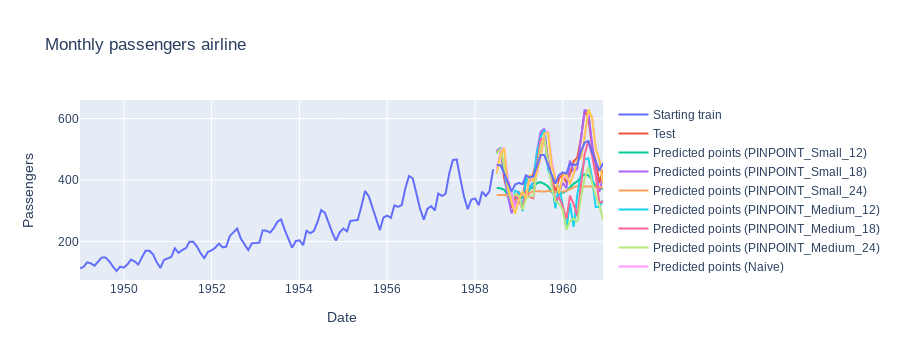

Forecast horizon: 3
MAE of model PINPOINT_Small_12: 33.30934315999349
MAE of model PINPOINT_Small_18: 20.826939595540363
MAE of model PINPOINT_Small_24: 38.729559936523444
MAE of model PINPOINT_Medium_12: 95.36336041768392
MAE of model PINPOINT_Medium_18: 68.26571589152017
MAE of model PINPOINT_Medium_24: 64.68692560831707
MAE of model Naive: 53.8
MAE of model ARIMA: 40.17347621028586
MAE of model Prophet: 34.2926421319963
RMSE of model PINPOINT_Small_12: 41.765114156958944
RMSE of model PINPOINT_Small_18: 24.995456926732253
RMSE of model PINPOINT_Small_24: 49.4291144654148
RMSE of model PINPOINT_Medium_12: 124.51458116919166
RMSE of model PINPOINT_Medium_18: 87.82860460779796
RMSE of model PINPOINT_Medium_24: 85.01271282551357
RMSE of model Naive: 62.78375586089128
RMSE of model ARIMA: 50.04555392616705
RMSE of model Prophet: 41.91664729240144
Plot and a comparison...


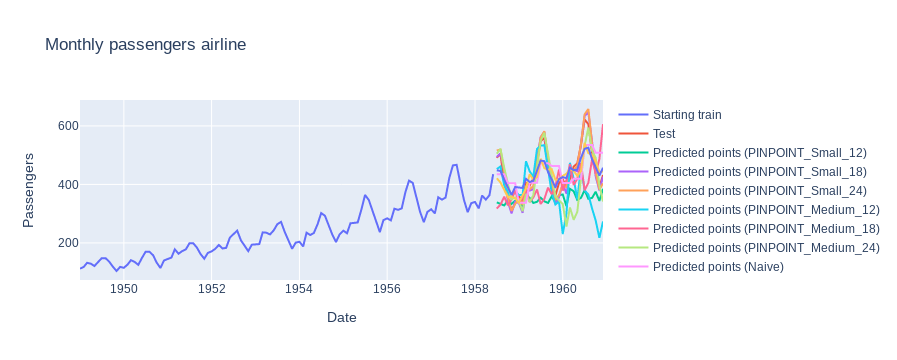

Forecast horizon: 6
MAE of model PINPOINT_Small_12: 19.92146036783854
MAE of model PINPOINT_Small_18: 21.48109405517578
MAE of model PINPOINT_Small_24: 21.39270050048828
MAE of model PINPOINT_Medium_12: 79.0010706837972
MAE of model PINPOINT_Medium_18: 86.50317690531412
MAE of model PINPOINT_Medium_24: 95.31320016860961
MAE of model Naive: 68.13333333333334
MAE of model ARIMA: 43.859494649419055
MAE of model Prophet: 32.144079955907756
RMSE of model PINPOINT_Small_12: 23.64387535444792
RMSE of model PINPOINT_Small_18: 25.236321164273846
RMSE of model PINPOINT_Small_24: 26.945983472194854
RMSE of model PINPOINT_Medium_12: 105.9832154286789
RMSE of model PINPOINT_Medium_18: 115.28061086011749
RMSE of model PINPOINT_Medium_24: 126.88675656088773
RMSE of model Naive: 78.24363658896911
RMSE of model ARIMA: 55.114299518583294
RMSE of model Prophet: 40.552456975156055
Plot and a comparison...


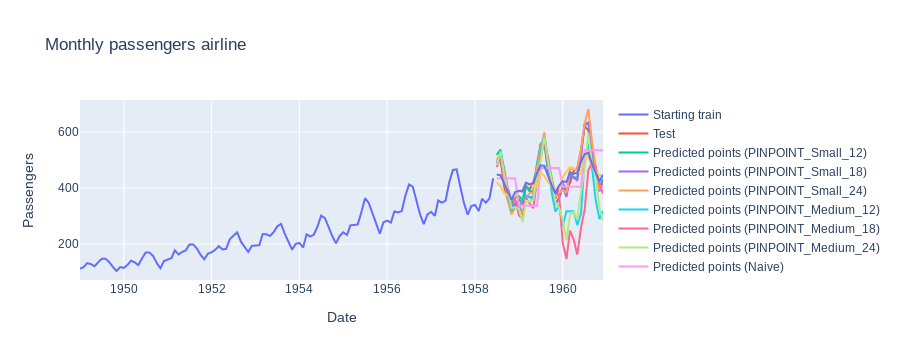

In [25]:
for forecast_horizon in forecast_horizons:
    final_result = final_results[forecast_horizon]
    
    forecasts = {}
    maes = {}
    rmses = {}
    
    for model_class in models:
        if model_class in ['ARIMA', 'Prophet', 'Naive']:
            forecasts[f"{model_class}"] = final_result[f"forecast_{model_class}"]
            maes[f"{model_class}"] = final_result[f"mae_{model_class}"]
            rmses[f"{model_class}"] = final_result[f"rmse_{model_class}"]
        else:
            for seq_length in seq_lengths:

                forecasts[f"{model_class}_{seq_length}"] = final_result[f"forecast_{model_class}_{seq_length}"]
                maes[f"{model_class}_{seq_length}"] = final_result[f"mae_{model_class}_{seq_length}"]
                rmses[f"{model_class}_{seq_length}"] = final_result[f"rmse_{model_class}_{seq_length}"]
   
    print(f"Forecast horizon: {forecast_horizon}")
    
    [print(f"MAE of model {model_class}: {x}") for model_class, x in maes.items()]
    [print(f"RMSE of model {model_class}: {x}") for model_class, x in rmses.items()]
    
    print("Plot and a comparison...")

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=train.append(validation).index, 
                             y=train.append(validation),
                             name='Starting train'))

    fig.add_trace(go.Scatter(x=test.index, 
                             y=test,
                             name='Test'))

    [fig.add_trace(go.Scatter(x=forecast.index, 
                              y=forecast,
                              name=f'Predicted points ({model_class})')) for model_class, forecast in forecasts.items()]

    fig.update_layout(title_text = plot_name)
    fig.update_xaxes(title_text = "Date")
    fig.update_yaxes(title_text = yaxis_name)
    fig.show()


In [26]:
for column in metrics.columns:
    print(metrics.loc[metrics.loc[:, column] == min(metrics.loc[:, column])])

                                    1         3          6
Model               Metric                                
PINPOINT_Small (18) MAE     22.511856  20.82694  21.481094
                                    1         3          6
Model               Metric                                
PINPOINT_Small (18) MAE     22.511856  20.82694  21.481094
                                    1          3         6
Model               Metric                                
PINPOINT_Small (12) MAE     29.263664  33.309343  19.92146


In [29]:
final_csv = metrics.loc[(['PINPOINT_Small (12)', 'PINPOINT_Medium (12)', 
              'Prophet', 'ARIMA', 'Naive']), :].astype("float64").round(2)

final_csv.columns = [f"{experiment_name}_{x}" for x in final_csv.columns]
final_csv = final_csv.rename(index={'PINPOINT_Small (12)': 'PINPOINT_Small', 
                                    'PINPOINT_Medium (12)': 'PINPOINT_Medium'})

final_csv.to_csv(f"results/{experiment_name}.csv")